# Deep Learning Project - Adult versus Children Classification
## BASELINE MODEL


## Installing TensorFlow and Keras

The deep learning packages, TensorFlow and Keras are not installed by default, but can be installed as follows:

In [1]:
#Installing TF and Keras (no needed for TFP)
if (FALSE){
    #Takes about 2 Minutes
    ptm <- proc.time()
        install.packages("tensorflow")
        install.packages("keras")
        install.packages("RCurl")
        install.packages("kableExtra")
        install.packages("reshape2")
    proc.time() - ptm
    #devtools::install_github("rstudio/keras") works ok but no tfp
}

## Imports

In the next cell, we load all the required libraries and functions. 

In [2]:
library(keras)
library(tensorflow)
tf$version$VERSION  #2.6.5
library(tidyverse)
require(graphics)

Loaded Tensorflow version 2.6.5



[1] "2.6.5"

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Data loading and preparing
In this notebook, we work with https://www.kaggle.com/datasets/die9origephit/children-vs-adults-images.

In [8]:
image_size_x = 32L
image_size_y = 32L

PATH_adult = '../input/children-vs-adults-images/train/adults/'
PATH_children = '../input/children-vs-adults-images/train/children/'
files_0 = dir(PATH_adult, pattern = '.jpg')
files_1 = dir(PATH_children, pattern = '.jpg')
(l0 = length(files_0))
(l1 = length(files_1))
X_train = array(dim=c(length(files_0) + length(files_1), image_size_x,image_size_y,3L))
y_train = rep(-1,length(files_0) + length(files_1))
loaded = 0 # Anzahl der Files die geladen wurden
## train adults einlesen
for (i in 1:length(files_0)){
        img <- keras::image_load(paste0(PATH_adult,files_0[i]), target_size = c(image_size_x, image_size_y))
        x <- keras::image_to_array(img)
        X_train[i,,,] = x
        y_train[i] = 0 # 0 = adult
        loaded = loaded + 1
      #if (i %% 20 == 0) cat(i)
}
## train children einlesen
for (i in 1:length(files_1)){
        img <- keras::image_load(paste0(PATH_children,files_1[i]), target_size = c(image_size_x, image_size_y))
        x <- keras::image_to_array(img)
        X_train[length(files_0) + i,,,] = x
        y_train[length(files_0) + i] = 1 # 1 = child
        loaded = loaded + 1
      #if (i %% 20 == 0) cat(i)
}
### test Daten einlesen
PATH_adult = '../input/children-vs-adults-images/test/adults/'
PATH_children = '../input/children-vs-adults-images/test/children/'
files_0 = dir(PATH_adult, pattern = '.jpg')
files_1 = dir(PATH_children, pattern = '.jpg')
(l0 = length(files_0))
(l1 = length(files_1))
X_test = array(dim=c(length(files_0) + length(files_1), image_size_x,image_size_y,3L))
y_test = rep(-1,length(files_0) + length(files_1))
loaded = 0 # Anzahl der Files die geladen wurden
## test adults einlesen
for (i in 1:length(files_0)){
        img <- keras::image_load(paste0(PATH_adult,files_0[i]), target_size = c(image_size_x, image_size_y))
        x <- keras::image_to_array(img)
        X_test[i,,,] = x
        y_test[i] = 0 # 0 = adult
        loaded = loaded + 1
      if (i %% 20 == 0) cat(i)
}
## test children einlesen
for (i in 1:length(files_1)){
        img <- keras::image_load(paste0(PATH_children,files_1[i]), target_size = c(image_size_x, image_size_y))
        x <- keras::image_to_array(img)
        X_test[length(files_0) + i,,,] = x
        y_test[length(files_0) + i] = 1 # 1 = child
        loaded = loaded + 1
      if (i %% 20 == 0) cat(i)
}

[1] 340

[1] 340

[1] 60

[1] 60

204060204060

## Look inside the data

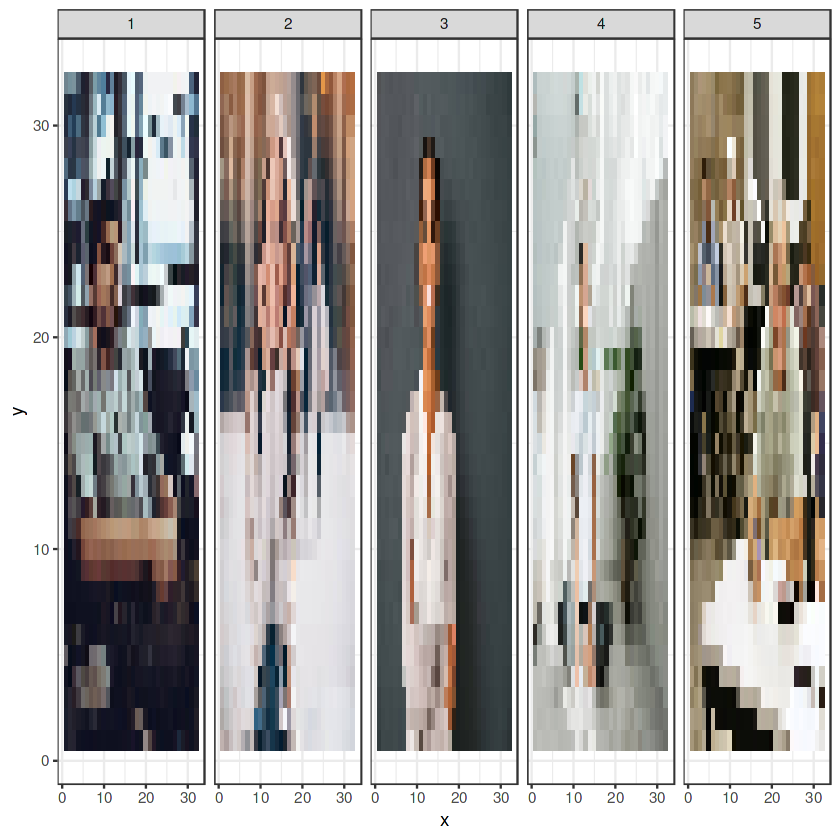

In [12]:
#have a look on the images:
dd <- expand.grid(1:32,1:32)
colnames(dd) <- c("x","y")
dd <- data.frame(x=rep(dd$x,5),y=rep(dd$y,5))
dd$r <- NA
dd$g <- NA
dd$b <- NA
dd$pic <- rep(1:5,each=32*32)
idx <- 32:1
idx2 <- c("r","g","b")

for (k in 1:5){
  for (j in 1:3){
    for (i in 1:32){
      dd[dd$y==idx[i] & dd$pic==k,idx2[j]] <- X_train[k,i,,j]
    }
  }
}
dd$r <- dd$r/255
dd$g <- dd$g/255
dd$b <- dd$b/255
ggplot(data=dd, aes(x=x, y=y, fill=rgb(r,g,b))) +
  geom_tile() +
  scale_fill_identity() +
  theme_bw()+
  facet_wrap(~pic,ncol=5)

[1] 1

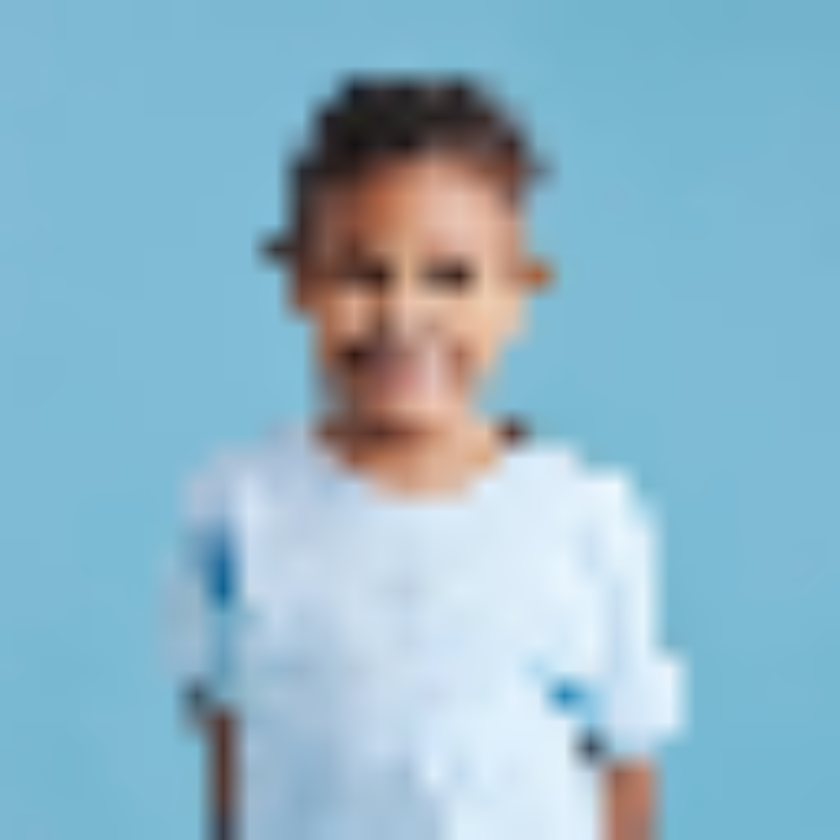

In [36]:
## Training set
library(grid)
idx = 600
grid.raster(X_train[idx,,,]/255) #Check a training image 
y_train[idx]

[1] 1

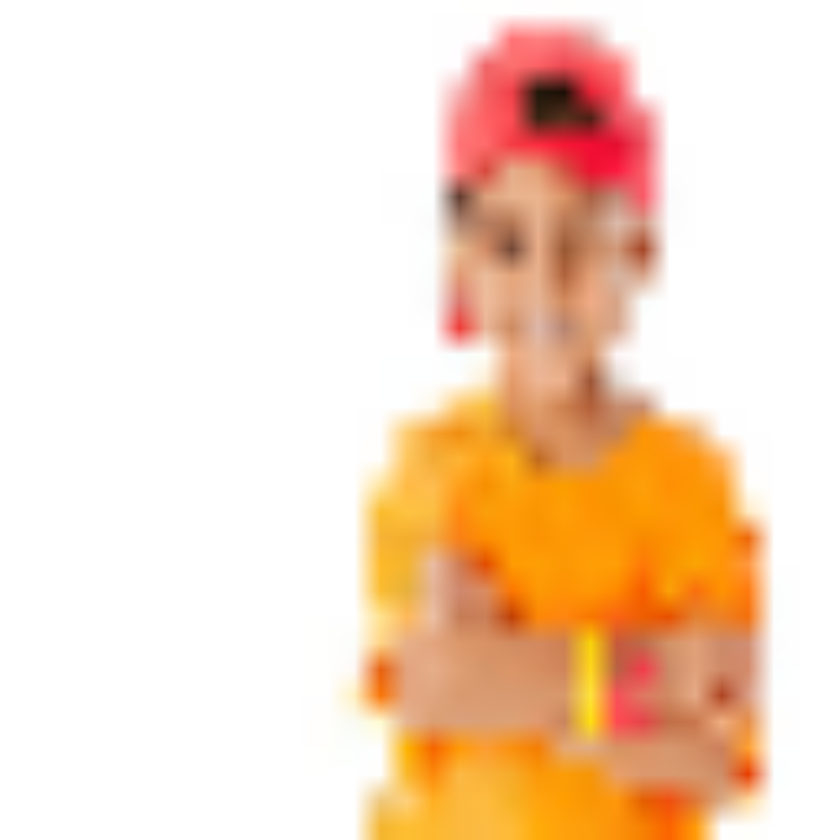

In [38]:
## Test set
idx2 = 89
grid.raster(X_test[idx2,,,]/255) #Check a test image 
y_test[idx2]

# Working with a pretrained VGG model

Let's instantiate the VGG16 model that was trained on the huge imageNet data (1000000 instances) with 1000 classes:

In [13]:
## edit from original keras function:
application_vgg16 = function (include_top = TRUE,
                              weights = "imagenet",
                              input_tensor = NULL,
                              input_shape = NULL,
                              pooling = NULL,
                              classes = 1000){
  # MP: comment out next line
  #verify_application_prerequistes()
  # MP: prefix "tf$" to next line.
  tf$keras$applications$VGG16(include_top = include_top, weights = weights, 
    input_tensor = input_tensor, 
    # MP: comment out next line, include succeeding line
    #input_shape = normalize_shape(input_shape)
    input_shape = input_shape, 
    pooling = pooling, classes = as.integer(classes))
}

In [14]:
base_model <- application_vgg16(weights = "imagenet",
                           include_top = FALSE,
                           input_shape = c(32L, 32L, 3L))
summary(base_model)

Model: "vgg16"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                [(None, 32, 32, 3)]             0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 32, 32, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 32, 32, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 16, 16, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 16, 16, 128)             73856       
________________________________________________________________________________
block2_conv2 

In [15]:
# i.e. freeze all convolutional VGG16 layers
freeze_weights(base_model)
#summary(base_model) # keine trainierbare Parameter mehr!

## Random Forest Model 

In [16]:
features = base_model$output %>% layer_flatten()
model_feature <- keras_model(
    inputs = base_model$input, 
    outputs = features)

In [17]:
X_train_features = model_feature(X_train)
#X_val_features = model_feature(X_val)
X_test_features = model_feature(X_test)

In [18]:
str(as.matrix(y_train))
str(as.matrix(X_train_features))

 num [1:680, 1] 0 0 0 0 0 0 0 0 0 0 ...
 num [1:680, 1:512] 57.17 16.02 0 1.03 34.01 ...


In [20]:
library(randomForest)
df_train = data.frame(
     #y = as.factor(as.character(y_train[1:1000])),
     y = as.factor(as.character(y_train)),
     as.matrix(X_train_features)
)
df_test = data.frame(
     #y = as.factor(as.character(y_test)),
     as.matrix(X_test_features)
)

In [21]:
rf = randomForest(y ~ ., df_train)

In [22]:
pred_rf = predict(rf, df_test)
(idx_wrong_basem = which(pred_rf != y_test))

[1]   1   4  11  13  14  18  21  25  27  30  38  39  43  47  56  62  63  69  70
[20]  71  72  74  78  82  86  87  88  94  95  98 107 109 113 115 118

In [23]:
(acc_rf = mean(pred_rf == as.factor(as.character(y_test))))

[1] 0.7083333

In [24]:
table(y_test)
table(pred_rf)
table(y_test , pred_rf)

y_test
 0  1 
60 60 

pred_rf
 0  1 
65 55 

      pred_rf
y_test  0  1
     0 45 15
     1 20 40

## Finetuning Model

In [25]:
# prepare new head for our project 
dropout_rate = 0.3
predictions <- base_model$output %>% 
    layer_flatten() %>% 
    #layer_dense(units = 100, activation = "relu") %>% # original
    #layer_dropout(rate = 0.2) %>% # original
    layer_dense(units = 256, activation = "relu") %>%
    layer_dropout(dropout_rate) %>% 
    layer_dense(units = 64, activation = "relu") %>%
    layer_dropout(dropout_rate) %>%
    layer_dense(units = 32, activation = "relu") %>%
    layer_dropout(dropout_rate) %>%
    layer_dense(units = 1, activation = "sigmoid")

In [26]:
summary(predictions)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")


In [27]:
# this is the model we will train
model <- keras_model(inputs = base_model$input, outputs = predictions)
# summary(model)

In [28]:
# compile model
model %>% compile(
  optimizer = "adam",
  #loss = 'categorical_crossentropy', # bei 2 und mehr Klassen
  loss = 'binary_crossentropy', # bei einer Klasse
  metrics = c("accuracy")
)

Finetune the VGG model (with frozen convolutional part) to the cifar10 data:

## Train, evaluate and compare the model

`geom_smooth()` using formula 'y ~ x'



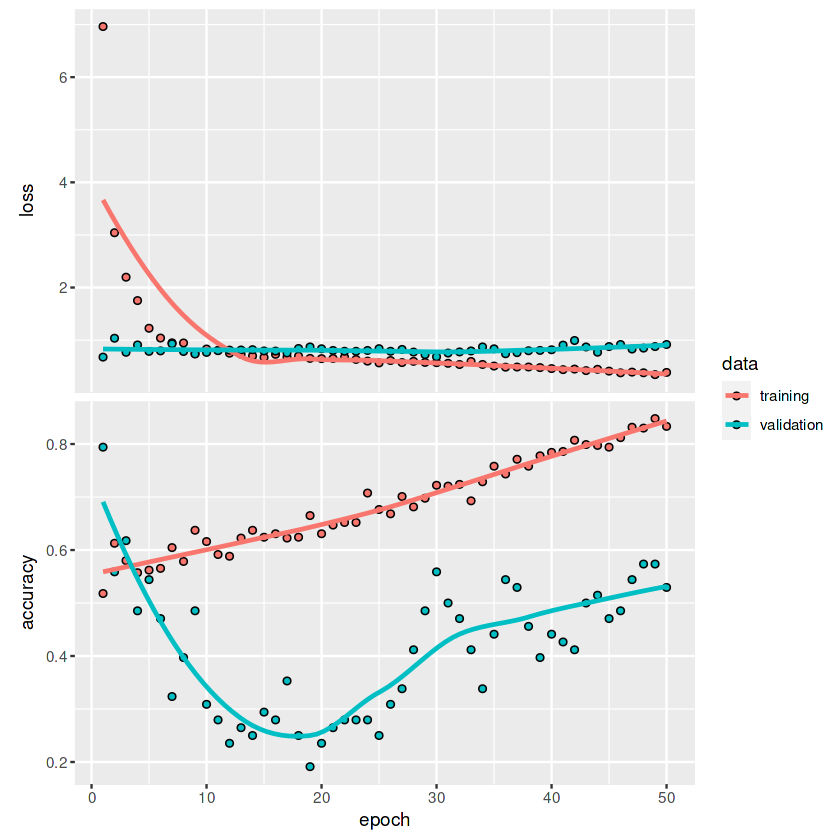

In [29]:
# train the model
history <- model %>% fit(
  X_train, y_train, 
  epochs = 50, # original: 20,
  batch_size=64, # original: 128,
  verbose=0,
  #validation_data=list(X_val,Y_val), # bei separatem validation set
  validation_split=0.1, #use 10% of training set as validation set
  shuffle = TRUE
)
plot(history)

In [30]:
results_fine <- model %>% evaluate(X_test, y_test, verbose=0)
results_fine

loss  accuracy 
0.7901481 0.6916667

In [39]:
# test set: loss, accuracy and confusion matrix
pred = predict(model, X_test)
evaluate(model,X_test, y_test)  # determines loss (average NLL) on test set
table(y_test)
y_pred = round(pred)
table(y_pred)
table(y_test , y_pred)

loss  accuracy 
0.7901481 0.6916667

[1] 0.7083333

y_test
 0  1 
60 60 

y_pred
 0  1 
75 45 

      y_pred
y_test  0  1
     0 49 11
     1 26 34

In [40]:
# RF (Baseline model): accuracy and confusion matrix
acc_rf
table(y_test)
table(pred_rf)
table(y_test , pred_rf)

[1] 0.7083333

y_test
 0  1 
60 60 

pred_rf
 0  1 
65 55 

      pred_rf
y_test  0  1
     0 45 15
     1 20 40

### Confusion Matrix Trainingset

In [33]:
# training set: loss, accuracy and confusion matrix
pred_train = predict(model, X_train)
evaluate(model,X_train, y_train)  # determines loss (average NLL) on test set
pred_train = round(pred_train)
table(y_train)
table(pred_train)
table(y_train, pred_train)

loss  accuracy 
0.2889252 0.8911765

y_train
  0   1 
340 340 

pred_train
  0   1 
400 280 

       pred_train
y_train   0   1
      0 333   7
      1  67 273

In [35]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] randomForest_4.6-14 forcats_0.5.2       stringr_1.4.1      
 [4] dplyr_1.0.10        purrr_0.3.4         readr_2.1.2        
 [7] tidyr_1.2.1         tibble_3.1.8        ggplot2_3.3.6      
[10] tidyverse_1.3.2     tensorflow_2.9.0    